来做一下之前说的用普通的深度神经网络来区分不同 layer 的 embedding（可能也包含position）
- 首先需要build数据集，数据集每条就是一个embedding，label有两个，一个是embedding是来自于哪个layer的，另一个是embedding是来自于哪个position的
  - 搭建一个 hook 来获取 embedding
  - 选定要用来 inference 的数据集

In [1]:
from exps.gpt2 import GPT2Wrapper
from typing import Any
import functools
import torch

# inference_max_len = 50 # 每个输入用于推理的句子的最大长度
            
    def task_inference(self, input):
        input_tokens = input.split(' ')
        input_tokens = input_tokens[:self.iml*2]
        input = ' '.join(input_tokens)
        # check if input > max_len tokens
        token_num = self.encode_input(input).shape[1]
        if token_num < self.iml:
            return None
        
        container = torch.zeros(self.iml, self.n_layer + 1, self.n_embd)
        container = self.inference(input, container) # [max_len, n_layer + 1, n_embd]
        original_shape = container.shape
        container = container.view(original_shape[0] * original_shape[1], original_shape[2]) # [max_len * (n_layer + 1), n_embd]

        # 现在 container 相当于是 max_len * (n_layer + 1) 个向量，每个向量是 n_embd 维的
        # 现在希望再拓展两个维度，变成 max_len * (n_layer + 1) 个 (n_embd + 2) 维的向量，后两维分别是 layer 和 position

        layer = torch.arange(self.n_layer + 1).repeat(self.iml).view(-1, 1).float() # [max_len * (n_layer + 1), 1]
        position = torch.arange(self.iml).repeat(self.n_layer + 1).view(-1, 1).float() # [max_len * (n_layer + 1), 1]
        container = torch.cat([container, layer, position], dim=1) # [max_len * (n_layer + 1), n_embd + 2]

        # 现在 container 是 max_len * (n_layer + 1) 个 (n_embd + 2) 维的向量
        return container

from torchtext import datasets
import random

def make_dataset(num, dataset='IMDB'):
    if dataset == 'IMDB':
        train_iter, _ = datasets.IMDB()
        train_data = list(train_iter)
        train_data: list[str] = [x[1] for x in train_data]
    else:
        raise ValueError('Unknown dataset')

    datapoints_num = len(train_data)

    assert num <= datapoints_num, 'Number of datapoints is too large'

    random.shuffle(train_data)
    train_data = train_data[:num]

    return train_data

In [2]:
task_cfg = {
    'model_name': 'gpt2',
    'inference_max_len': 50,
    'dataset_datapoints_num': 500,
}

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

def run(config):
    model_name = config['model_name']
    inference_max_len = config['inference_max_len']
    dataset_datapoints_num = config['dataset_datapoints_num']

    # 创建模型
    model = Model(model_name, inference_max_len)
    tokenizer = model.tokenizer

    # 数据集创建
    train_data = make_dataset(dataset_datapoints_num)
    dataset = torch.zeros(dataset_datapoints_num * inference_max_len * (model.n_layer + 1), model.n_embd + 2)
    processed_idx = 0

    for i, x in enumerate(train_data):
        container = model.task_inference(x)
        if container is None:
            print(f'Warning: {i}th data is too short')
            continue

        dataset[processed_idx:processed_idx+inference_max_len*(model.n_layer+1)] = container
        processed_idx += inference_max_len * (model.n_layer + 1)

    dataset = dataset[:processed_idx]

    # 训练线性回归模型
    n_samples, n_features = config['dataset_datapoints_num'], model.n_embd  # 样本数和特征数
    n_classes = model.n_layer + 1  # 类别数

    X_train, X_test, Y_train, Y_test = train_test_split(dataset[:, :-2], dataset[:, -2], test_size=0.2, random_state=0)
    X_train = torch.tensor(X_train, dtype=torch.float32)
    Y_train = torch.tensor(Y_train, dtype=torch.long)
    X_test = torch.tensor(X_test, dtype=torch.float32)
    Y_test = torch.tensor(Y_test, dtype=torch.long)

    # 数据加载器
    dataset = TensorDataset(X_train, Y_train)
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # 定义模型
    class LogisticRegressionModel(nn.Module):
        def __init__(self, n_input_features, n_output_classes):
            super(LogisticRegressionModel, self).__init__()
            self.linear = nn.Linear(n_input_features, n_output_classes)

        def forward(self, x):
            return self.linear(x)

    model = LogisticRegressionModel(n_features, n_classes)

    # 损失函数和优化器
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # 训练模型
    n_epochs = 100  # 训练轮数

    # use tqdm to show progress, and collect loss, draw a loss curve finally
    loss_list = []
    for epoch in tqdm(range(n_epochs)):
        for X, Y in dataloader:
            # forward pass
            Yhat = model(X)
            loss = criterion(Yhat, Y)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_list.append(loss.item())

    # 训练完毕，创建一个新的画布，绘制 loss 曲线
    plt.plot(loss_list)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # 测试模型
    model.eval()
    with torch.no_grad():
        Yhat = model(X_test)
        _, Yhat = Yhat.max(1)
        accuracy = (Yhat == Y_test).sum().item() / Y_test.size(0)
        print(f'Accuracy: {accuracy}', "cfg = ", config)

In [3]:
run(task_cfg)

74th data is too short
275th data is too short
315th data is too short
381th data is too short


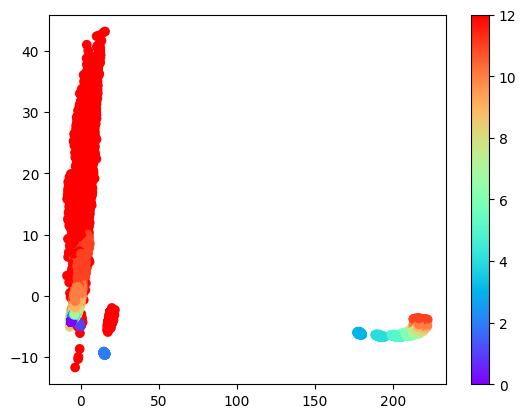

In [4]:
# # PCA reduction baseline
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# pca = PCA(n_components=2)
# # 截取 dataset 前 n_embd 列
# dataset_forPCA = dataset[:, :model.n_embd]
# # normalize
# dataset_forPCA = (dataset_forPCA - dataset_forPCA.mean()) / dataset_forPCA.std()
# dataset_layer = dataset[:, model.n_embd]

# # PCA 降维
# dataset_forPCA = pca.fit_transform(dataset_forPCA)

# # 绘制 PCA 降维结果, 每个点的颜色代表其所在的 layer, 色谱使用rainbow
# plt.scatter(dataset_forPCA[:, 0], dataset_forPCA[:, 1], c=dataset_layer, cmap='rainbow')
# plt.colorbar()
